# **Deep Learning HW2 - Problem 3**
### **Ehsan Sharifian 400201529**

---

## **Initialization**

In [1]:
!pip install -q transformers
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 8.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 13.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoConfig, AutoTokenizer, AutoModel
from torchmetrics import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
ParsBERT_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

# from transformers import BertConfig, BertTokenizer, BertModel
# config = BertConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")
# tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")
# ParsBERT_model = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


## **Part a**

### Create Dataframe

In [5]:
! git clone https://github.com/amnghd/Persian_poems_corpus
dir = '/content/Persian_poems_corpus/normalized/'

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (148/148), done.


In [6]:
def DataFrame_Maker(poets_list, n_row):
  list_of_dataframes = []
  for i, poet in enumerate(poets_list):
    df = pd.read_csv(dir + poet + '_norm.txt' , header = None, names= ['clause'])
    df = df.groupby(df.index // n_row).agg(' '.join)
    df['poet'] = poet
    df['poet_index'] = i
    list_of_dataframes.append(df)
  return pd.concat(list_of_dataframes).reset_index(drop=True).sample(frac=1)

In [7]:
poets_list = ['bahar','ferdousi','attar','iqbal','moulavi','parvin','saadi','farrokhi','jami','saeb']
df = DataFrame_Maker(poets_list, 2)
print(set(df['poet']))
df.head(10)

{'bahar', 'attar', 'parvin', 'moulavi', 'ferdousi', 'saeb', 'jami', 'iqbal', 'saadi', 'farrokhi'}


,clause,poet,poet_index
54866,جز او را نخواهیم کس پادشا اگر دادگر باشد و پارسا,ferdousi,1
76326,فرید از یک شکن زنار اگر بربست من با او به سوی ...,attar,2
111547,هر آنکو طالب این کار نبود مقامش اندرین ره یار ...,attar,2
197376,عشق تو خوشی چو قصد خونریز کند جان از قفس قالب ...,moulavi,4
11640,دوم آیین جمشید ستوده سوم اورنگی است ای یار ...,bahar,0
395,حق از ازل به مهر و ولای او با خلق بسته عهد موک...,bahar,0
137693,طلب میکردمت اندر جدایی که تا دریافتم از آشنایی,attar,2
2962,شاعر فحل خراسانم که در دریای نظم طبع من کشتی ف...,bahar,0
93826,نداری دل که در دلداری ما دمی دل سوزدت بر زاری ما,attar,2
173484,ولی بنوازمش با ناخن شیر که او را تار از رگهای ...,iqbal,3


###  Handling Unbalanced Data

In [8]:
cutting_point = 1e8
for poet in poets_list:
  length = len(df[df['poet'] == poet])
  if (cutting_point > length):
    cutting_point = length

list_of_dataframes = []
for poet in poets_list:
  list_of_dataframes.append(df[df['poet'] == poet].sample(n=cutting_point).reset_index(drop=True))

new_df = pd.concat(list_of_dataframes)
new_df = new_df.sample(frac=1).reset_index(drop=True)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55730 entries, 0 to 55729
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clause      55730 non-null  object
 1   poet        55730 non-null  object
 2   poet_index  55730 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


### Create CustomDataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.clause = dataframe.clause
        self.targets = dataframe.poet_index
        self.max_len = max_len

    def __len__(self):
        return len(self.clause)

    def __getitem__(self, index):
        clause = str(self.clause[index])
        clause = " ".join(clause.split())

        inputs = self.tokenizer.encode_plus(
            clause,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'targets': torch.tensor(self.targets[index])
        }

In [10]:
ratio_1 = 0.8
ratio_2 = 0.9
MAX_LENGTH = 40

train_df_temp = new_df.sample(frac=ratio_1)
test_df = new_df.drop(train_df_temp.index).reset_index(drop=True)
train_df_temp = train_df_temp.reset_index(drop=True)
train_df = train_df_temp.sample(frac=ratio_2)
validation_df = train_df_temp.drop(train_df.index).reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

print(f"FULL Dataset: {new_df.shape}")
print(f"TRAIN Dataset: {train_df.shape}")
print(f"VALIDATION Dataset: {validation_df.shape}")
print(f"TEST Dataset: {test_df.shape}")

training_set = CustomDataset(train_df, tokenizer, MAX_LENGTH)
validation_set = CustomDataset(validation_df, tokenizer, MAX_LENGTH)
testing_set = CustomDataset(test_df, tokenizer, MAX_LENGTH)

FULL Dataset: (55730, 3)
TRAIN Dataset: (40126, 3)
VALIDATION Dataset: (4458, 3)
TEST Dataset: (11146, 3)


### Create DataLoader


In [11]:
TRAIN_BATCH_SIZE = 100
VALID_BATCH_SIZE = 100
TEST_BATCH_SIZE = 100

training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=VALID_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testing_set, batch_size=TEST_BATCH_SIZE, shuffle=True)

### Create Model


In [12]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, base_model):
        super(NeuralNetwork, self).__init__()
        self.l1 = base_model
        self.l2 = torch.nn.Sequential(
                                  torch.nn.Dropout(0.5),
                                  torch.nn.Linear(768, 10),
        )
        
    
    def forward(self, ids, mask, token_type_ids):
        output_1= self.l1(input_ids = ids, attention_mask = mask, token_type_ids = token_type_ids)
        output = self.l2(output_1['pooler_output'])
        return output

    def freeze_all_but_last(self):
        for n, p in self.named_parameters():
          if ('l2' in n):
              pass
          else:
              p.requires_grad = False

    def train_all(self):
        for p in self.parameters():
            p.requires_grad = True

### Create Optimizer

In [13]:
class nn_optimizer():
    def __init__(self, model, train_dataloader, validation_dataloader, test_dataloader, optimizer, loss_fn, epochs, scheduler):
      self.model = model
      self.train_dataloader = train_dataloader
      self.validation_dataloader = validation_dataloader
      self.test_dataloader = test_dataloader
      self.optimizer = optimizer
      self.loss_fn = loss_fn
      self.epochs = epochs
      self.scheduler = scheduler
      self.confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=10).to(device)

    def train_loop(self):
      self.model.train()
      size = len(self.train_dataloader.dataset)
      for batch, dictionary in enumerate(self.train_dataloader):
          ids = dictionary['ids'].to(device)
          mask = dictionary['mask'].to(device)
          token_type_ids = dictionary['token_type_ids'].to(device)
          targets = dictionary['targets'].to(device)

          # Compute prediction and loss
          pred = self.model(ids, mask, token_type_ids)
          loss = self.loss_fn(pred, targets)

          # Backpropagation
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
          if (self.scheduler):
            self.scheduler.step()

          if batch % 100 == 0:
              loss, current = loss.item(), batch * len(ids)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    def test_loop(self, name):
        if (name == 'train'):
          dataloader = self.train_dataloader
        elif (name == 'test'):
          dataloader = self.test_dataloader
        elif (name == 'validation'):
          dataloader = self.validation_dataloader
        self.model.eval()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0
        confusion_matrix = torch.zeros((10, 10), dtype=int).to(device)

        with torch.no_grad():
            for dictionary in dataloader:
                ids = dictionary['ids'].to(device)
                mask = dictionary['mask'].to(device)
                token_type_ids = dictionary['token_type_ids'].to(device)
                targets = dictionary['targets'].to(device)

                pred = self.model(ids, mask, token_type_ids)
                test_loss += self.loss_fn(pred, targets).item()
                correct += (pred.argmax(1) == targets).type(torch.float).sum().item()
                confusion_matrix += self.confusion_matrix(targets , pred.argmax(1))

        test_loss /= num_batches
        correct /= size
        TP = torch.diag(confusion_matrix)
        FP = torch.sum(confusion_matrix, axis=0) - TP
        FN = torch.sum(confusion_matrix, axis=1) - TP
        precision = (torch.sum(TP)/(torch.sum(TP)+torch.sum(FP))).item()
        recall = (torch.sum(TP)/(torch.sum(TP)+torch.sum(FN))).item()
        micro_f1_score = (2*precision*recall)/(precision+recall)
        print(f"{name} Accuracy: {(100*correct):>0.1f}%, {name} Avg loss: {test_loss:>8f}")
        return correct, test_loss, micro_f1_score, confusion_matrix

    def fit(self):
        for t in range(self.epochs):
          print(f"Epoch {t+1}\n-------------------------------------")
          self.train_loop()
          self.test_loop('train')
          self.test_loop('validation')
          print('\n')
        print("Done!")

### fit the model

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

model = NeuralNetwork(ParsBERT_model)
model.freeze_all_but_last()
model.to(device)

EPOCHS = 20
LEARNING_RATE = 4e-4
total_steps = len(training_loader) * EPOCHS
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=5,
    num_training_steps=total_steps
)
loss_fn = torch.nn.CrossEntropyLoss()

# EPOCHS = 10
# LEARNING_RATE = 1e-4
# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

optimizer = nn_optimizer(model, training_loader, validation_loader, test_loader, optimizer, loss_fn, EPOCHS, scheduler)
optimizer.fit()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1
-------------------------------------
loss: 2.373730  [    0/40126]
loss: 2.166950  [10000/40126]
loss: 2.153939  [20000/40126]
loss: 2.069481  [30000/40126]
loss: 2.075620  [40000/40126]
train Accuracy: 32.6%, train Avg loss: 1.955157
validation Accuracy: 32.6%, validation Avg loss: 1.947716


Epoch 2
-------------------------------------
loss: 1.994798  [    0/40126]
loss: 2.118722  [10000/40126]
loss: 1.946833  [20000/40126]
loss: 2.098224  [30000/40126]
loss: 1.916010  [40000/40126]
train Accuracy: 33.8%, train Avg loss: 1.924065
validation Accuracy: 34.1%, validation Avg loss: 1.919049


Epoch 3
-------------------------------------
loss: 2.009465  [    0/40126]
loss: 2.008317  [10000/40126]
loss: 1.968317  [20000/40126]
loss: 1.949189  [30000/40126]
loss: 2.024316  [40000/40126]
train Accuracy: 34.1%, train Avg loss: 1.907221
validation Accuracy: 35.0%, validation Avg loss: 1.899113


Epoch 4
-------------------------------------
loss: 2.164096  [    0/40126]
loss: 1.9120

### accuracy, loss, f1 score, and confusion matrix

test Accuracy: 35.7%, test Avg loss: 1.879794
test micro_f1 score: 0.3574


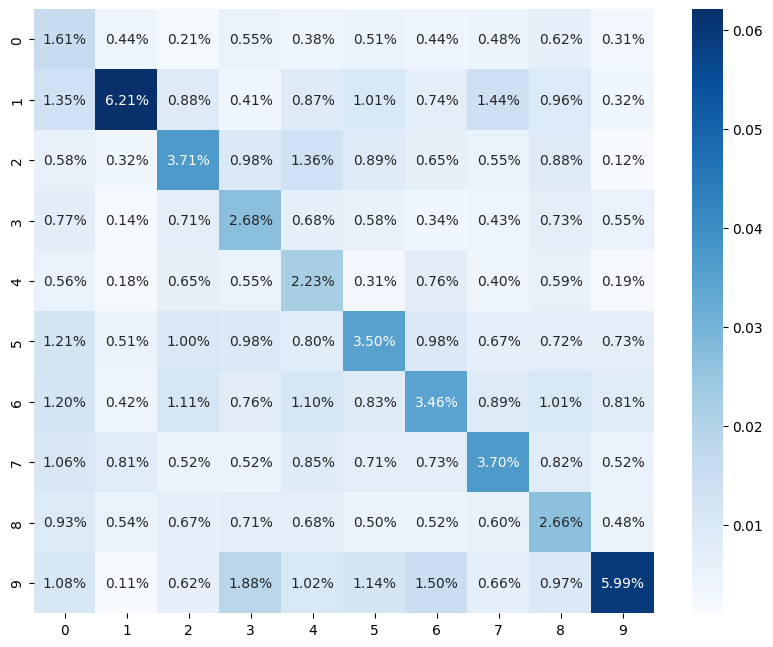

In [ ]:
correct, test_loss, micro_f1_score, confusion_matrix = optimizer.test_loop('test')
print(f"test micro_f1 score: {micro_f1_score:>0.4f}")
plt.figure(figsize=(10, 8), dpi = 100)
confusion_matrix = confusion_matrix.detach().to('cpu').numpy()
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot= True, fmt='.2%', cmap=plt.cm.Blues);
plt.show()

## **Part b**


### Adam: fit the model

In [14]:
ParsBERT_model_2 = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
model_2 = NeuralNetwork(ParsBERT_model_2)
model_2.train_all()
model_2.to(device)

# EPOCHS_2 = 7
# LEARNING_RATE_2 = 4e-4
# total_steps = len(training_loader) * EPOCHS_2
# optimizer_2 = AdamW(model_2.parameters(), lr=LEARNING_RATE_2, correct_bias=False)
# scheduler_2 = get_linear_schedule_with_warmup(
#     optimizer_2,
#     num_warmup_steps=5,
#     num_training_steps=total_steps
# )
# loss_fn_2 = torch.nn.CrossEntropyLoss()

EPOCHS_2 = 8
LEARNING_RATE_2 = 1e-5
loss_fn_2 = torch.nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(params =  model_2.parameters(), lr=LEARNING_RATE_2)

optimizer_2 = nn_optimizer(model_2, training_loader, validation_loader, test_loader, optimizer_2, loss_fn_2, EPOCHS_2, scheduler=None)
optimizer_2.fit()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncati

Epoch 1
-------------------------------------


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


loss: 2.385208  [    0/40126]
loss: 2.035453  [10000/40126]
loss: 1.808956  [20000/40126]
loss: 1.649569  [30000/40126]
loss: 1.516173  [40000/40126]
train Accuracy: 53.7%, train Avg loss: 1.376968
validation Accuracy: 50.4%, validation Avg loss: 1.453461


Epoch 2
-------------------------------------
loss: 1.491051  [    0/40126]
loss: 1.382239  [10000/40126]
loss: 1.227723  [20000/40126]
loss: 1.159108  [30000/40126]
loss: 1.107426  [40000/40126]
train Accuracy: 67.8%, train Avg loss: 0.977067
validation Accuracy: 59.0%, validation Avg loss: 1.205149


Epoch 3
-------------------------------------
loss: 1.264256  [    0/40126]
loss: 1.282308  [10000/40126]
loss: 0.994332  [20000/40126]
loss: 0.843767  [30000/40126]
loss: 1.049709  [40000/40126]
train Accuracy: 77.5%, train Avg loss: 0.711933
validation Accuracy: 63.9%, validation Avg loss: 1.089790


Epoch 4
-------------------------------------
loss: 0.722371  [    0/40126]
loss: 0.848368  [10000/40126]
loss: 0.702324  [20000/40126

### Adam: accuracy, loss, f1 score, and confusion matrix

test Accuracy: 68.4%, test Avg loss: 1.169170
test micro_f1 score: 0.6837


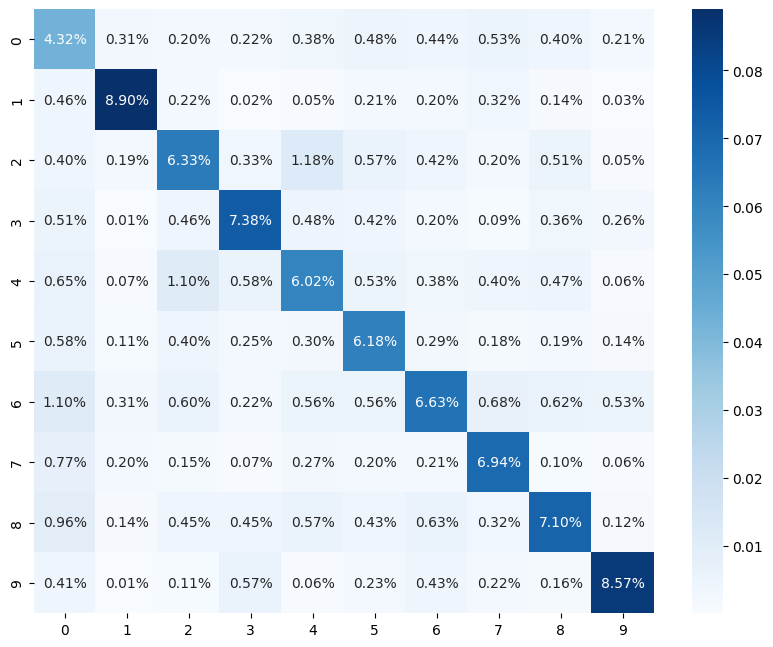

In [15]:
correct, test_loss, micro_f1_score, confusion_matrix = optimizer_2.test_loop('test')
print(f"test micro_f1 score: {micro_f1_score:>0.4f}")
plt.figure(figsize=(10, 8), dpi = 100)
confusion_matrix = confusion_matrix.detach().to('cpu').numpy()
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot= True, fmt='.2%', cmap=plt.cm.Blues);
plt.show()

### SGD: fit the model

In [ ]:
ParsBERT_model_3 = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
model_3 = NeuralNetwork(ParsBERT_model_3)
model_3.train_all()
model_3.to(device)

# EPOCHS_3 = 7
# LEARNING_RATE_3 = 4e-4
# total_steps = len(training_loader) * EPOCHS_3
# optimizer_3 = torch.optim.SGD(model_3.parameters(), lr=LEARNING_RATE_3)
# scheduler_3 = get_linear_schedule_with_warmup(
#     optimizer_3,
#     num_warmup_steps=5,
#     num_training_steps=total_steps
# )
# loss_fn_3 = torch.nn.CrossEntropyLoss()

EPOCHS_3 = 10
LEARNING_RATE_3 = 1e-5
loss_fn_3 = torch.nn.CrossEntropyLoss()
optimizer_3 = torch.optim.SGD(params =  model_3.parameters(), lr=LEARNING_RATE_3)

optimizer_3 = nn_optimizer(model_3, training_loader, validation_loader, test_loader, optimizer_3, loss_fn_3, EPOCHS_3, scheduler=None)
optimizer_3.fit()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1
-------------------------------------
loss: 2.437391  [    0/40126]
loss: 2.370319  [10000/40126]
loss: 2.399834  [20000/40126]
loss: 2.461103  [30000/40126]
loss: 2.462488  [40000/40126]
train Accuracy: 9.9%, train Avg loss: 2.352928
validation Accuracy: 9.2%, validation Avg loss: 2.358597


Epoch 2
-------------------------------------
loss: 2.393385  [    0/40126]
loss: 2.381357  [10000/40126]
loss: 2.429692  [20000/40126]
loss: 2.359361  [30000/40126]
loss: 2.453474  [40000/40126]
train Accuracy: 9.8%, train Avg loss: 2.335974
validation Accuracy: 9.1%, validation Avg loss: 2.340904


Epoch 3
-------------------------------------
loss: 2.443731  [    0/40126]
loss: 2.316437  [10000/40126]
loss: 2.391141  [20000/40126]
loss: 2.442097  [30000/40126]
loss: 2.328263  [40000/40126]
train Accuracy: 9.8%, train Avg loss: 2.324825
validation Accuracy: 9.4%, validation Avg loss: 2.329055


Epoch 4
-------------------------------------
loss: 2.381228  [    0/40126]
loss: 2.420207  [1

### SGD: accuracy, loss, f1 score, and confusion matrix

test Accuracy: 12.2%, test Avg loss: 2.297730
test micro_f1 score: 0.1216


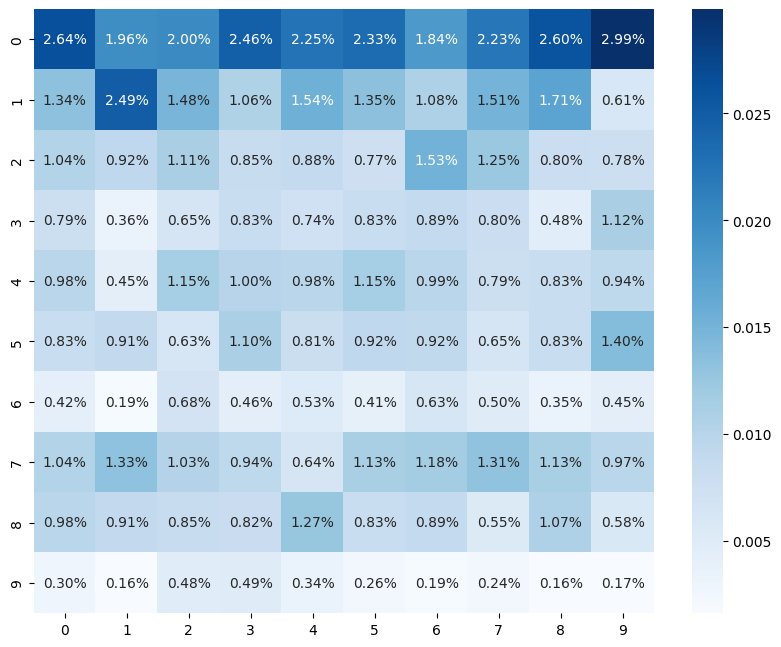

In [ ]:
correct, test_loss, micro_f1_score, confusion_matrix = optimizer_3.test_loop('test')
print(f"test micro_f1 score: {micro_f1_score:>0.4f}")
plt.figure(figsize=(10, 8), dpi = 100)
confusion_matrix = confusion_matrix.detach().to('cpu').numpy()
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot= True, fmt='.2%', cmap=plt.cm.Blues);
plt.show()

## **part c**


### Compute Perplexity


In [21]:
def unbiased_sample_Maker(poets_list, n_row, n_sample):
  list_of_dataframes = []
  for i, poet in enumerate(poets_list):
    df = pd.read_csv(dir + poet + '_norm.txt' , header = None, names= ['clause'])
    df = df.groupby(df.index // n_row).agg(' '.join)
    df = df.sample(n=n_sample, replace=False)
    list_of_dataframes.append(df)
  final_pd = pd.concat(list_of_dataframes).reset_index(drop=True).sample(frac=1)
  return list(final_pd['clause'])

In [17]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [26]:
import evaluate
perplexity = evaluate.load("perplexity", module_type="metric")
poets_list = ['bahar','ferdousi','attar','iqbal','moulavi','parvin','saadi','farrokhi','jami','saeb']
input_texts = unbiased_sample_Maker(poets_list, n_row=2, n_sample=100)

without_fine_tuning_results = perplexity.compute(model_id='HooshvareLab/bert-fa-base-uncased',
                             add_start_token=False,
                             predictions=input_texts)
print(f'{list(without_fine_tuning_results.keys())}')
print(f'perplexity without fine-tuning {round(without_fine_tuning_results["mean_perplexity"], 2)}\n')
print('-----------------------------------------------------------------\n')

ParsBERT_model_2.save_pretrained('./fine_tuned_model_configs')
tokenizer.save_pretrained('./fine_tuned_model_configs')

with_fine_tuning_results = perplexity.compute(model_id='./fine_tuned_model_configs',
                             add_start_token=False,
                             predictions=input_texts)
print(f'perplexity with fine-tuning {round(with_fine_tuning_results["mean_perplexity"], 2)}')

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/63 [00:00<?, ?it/s]

['perplexities', 'mean_perplexity']
perplexity without fine-tuning 3200419.09

-----------------------------------------------------------------



If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of BertLMHeadModel were not initialized from the model checkpoint at ./fine_tuned_model_configs and are newly initialized: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/63 [00:00<?, ?it/s]

perplexity with fine-tuning 133166.75


<div dir='rtl'> <font size='4'>
همان‌‌طور که انتظار داشتیم، perplexity یا همان میزان شگفت‌زدگی مدل بعد از 
fine-tuning
به شدت کاهش یافته است زیرا مدل جدید نسبت به دیتاست جدیدی که شامل ابیات بوده دوباره آموزش دیده است و ابیات این دیتاست برای این مدل بازآموزش‌دیده‌شده محتمل‌تر است.
</font> </div>